In [2]:
from svm import SVM # implementation of kernel SVM

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import pandas as pd

from helpers import plot_cm, accuracy, recall, precision, plot_prediction # implementation of some auxiliary functions

# Cieľ

V tomto protokole by som rád preskúmal možnosti algoritmu support vector machine na binárnu klasifikáciu.
Ako dataset som vybral tzv. `Heart Failure Prediction Dataset`
(https://www.kaggle.com/fedesoriano/heart-failure-prediction). Algoritmus
support vector machine vyskúšam s troma jadrami (`kernel`) a to konkrétne s lineárnym, polynomiálnym a s využitím
tzv. `radial basis function` jadra.

## Teoretické pozadie

Na implementáciu SVM použijem upravenú  `Hinge loss` s použitím `kernel-tricku`, ktorú budem optimalizovať pomocou
algoritmu `gradient descent` namiesto kvadratickej optimalizácie.

`Hinge loss` nadobúda tvar:
\begin{align}
\mathcal{J} (w, b)
&= C\sum_{i=0}^n max(0, 1-y_i(w^Tx_i+b)) + \frac{1}{2}w^Tw
\end{align}

V tomto zápise značí $w$ vektor váh a $b$ je konštantný člen. Vektor $x_i \in R^{p, 1}$ je i-ty prvok dizajnovej matice
$X \in R^{p, n}$ t.j. $x_i$ je i-ta vzorka dát. A nakoniec $y_i \in \{-1, 1\}$ je príslušná trieda k tejto i-tej vzorke dát.

Reparametrizujme $w := \Phi(X)\alpha$ kde $\alpha \in R^{n, 1}$ a $\Phi(X)$ je zobrazenie pôvodnej dizajnovej matice $X$.
Z tohto plynie že $w^T\Phi(X)=\alpha^TK$ a $w^Tw = \alpha^TK\alpha$. Pričom $K=\Phi(X)^T\Phi(X)$ je tzv.
`kernel` matica ($K \in R^{n, n}$) tiež známa ako Gramova matica. Zavedením `kernel` matice nám umožní pomocou tzv.
`representer` teorému
presunúť problém do duálneho priestoru a aplikovať známy `kernel-trick`, ktorý spočíva práve v použití gramovej matice
(`kernel` matica) namiesto explicitného výpočtu skalárneho súčinu medzi $\Phi(X)^T\Phi(X)$ resp. bez explicitne známeho
predpisu pre transformáciu $\Phi$.

Reparametrizáciou sme získali `Hinge loss` v duálnom tvare:
\begin{align}
\mathcal{J} (\alpha, b)
&= C\sum_{i=0}^n max(0, 1-y_i(\alpha^TK^{(i)}+b)) + \frac{1}{2}\alpha^TK\alpha
\end{align}

Pravidlo pre aktualizáziu váh ($\alpha$, b) teda bude znieť:
Pre každé $i \in \hat{n}$
\begin{equation}
\\
\alpha^{i+1} = \alpha^{i} - \eta(K\alpha-Cy_iK^{(i)}) \\
b^{i+1}=b^i + \eta Cy_i
\end{equation}
ak $1 > y_i(\alpha^TK^{(i)}+b)$

inak

\begin{equation}
\\
\alpha^{i+1} = \alpha^{i} - \eta K \alpha \\
b^{i+1}=b^i
\end{equation}

# Dataset

Ako už bolo spomenuté tak ako dataset som vybral `Heart Failure Prediction Dataset` obsahujúci 11 príznakov popisujúcich
binárnu odozvu vyjadrujúci náchylnosť na zlyhanie srdca daného pacienta. Náhľad na dataset vidíme nižšie.

In [3]:
data = pd.read_csv('heart.csv')

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Popis jednotlivých príznakov je nasledujúci:
* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results
    [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal]

Z popisu aj náhľadu na dataset je jasné, že budeme musieť vykonať isté transformácie dát ako napr. `dummy encoding`
alebo `one-hot encoding`nominálnych kategorických prediktorov a to konkrétne:
 `Sex`, `ChestPainType`, `FastingBS`, `RestingECG`
, `ExerciseAngina`, `ST_Slope`. Odozvu `HearthDisease` taktiež prevedieme na tvar: [1: heart disease, -1: Normal].

Pred tvorbou modelu by sme mali správne preskúmať vzťahy medzi jednotlivými premennými a to preskúmať korelácie
medzi spojitými premennými ale aj voči odozve. V prípade odozvy a kategorických premenných by malo význam preskúmať vzťah
pomocou napr. `One-way anova` testom a nakoniec vťahy kategorických premenných pomocou Chi-Squared testu. Druhou možnosťou
by bolo využiť `cross-validation` a takto v podstate hrubou silou vybrať množinu najvhodnejších príznakov. Obe metódy sú
ale časovo náročné preto sa pokúsim vystavať model pomocou všetkých dostupných príznakov resp. pomocou `PCA` s dvomi
komponentami čo nám umožní vykresliť rozhodvaciu nadrovinu v 2D.


In [4]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
# dummy encoding
colnames = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]
for col in colnames:
    dummies = pd.get_dummies(data[col], drop_first=True, prefix=data[col].name)
    data = pd.concat([data, dummies], axis='columns')
    data.drop(columns=data[col].name, axis=1, inplace=True) # We have to drop columns to aviod multi-collinearity

data.loc[data['HeartDisease'] == 0, 'HeartDisease'] = -1  # -1 normal

data.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,172,0.0,-1,1,1,0,0,0,1,0,0,0,1
1,49,160,180,156,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,130,283,98,0.0,-1,1,1,0,0,0,0,1,0,0,1
3,48,138,214,108,1.5,1,0,0,0,0,0,1,0,1,1,0
4,54,150,195,122,0.0,-1,1,0,1,0,0,1,0,0,0,1


# Príprava dát

In [6]:
# 1. Prepare data
X, y = data.iloc[:, :-2].to_numpy(), data['HeartDisease'].to_numpy()


# 2. Scale data for stability of calculation (there were float overflow with linear and polynomial kernels)
minmax = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
X = minmax.fit_transform(X)

# 3. Reduce dimensionality of data on 2 features
pca = PCA(svd_solver='full', n_components=2)
X_pca = pca.fit_transform(X)

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=1234)

# SVM s lineárnym jadrom

Môžme sa pokúsiť separovať dáta pomocou nadroviny, teda lineárne ale to pravdepodobne nebude fungovať.

 58%|█████▊    | 873.0/1500 [00:21<00:15, 40.18it/s]


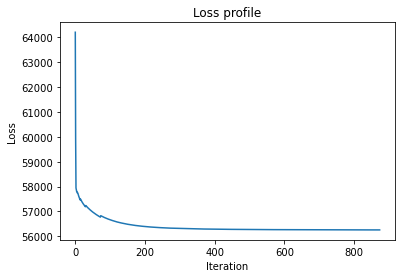

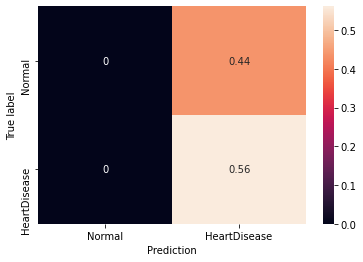

Classifier accuracy is: 0.5615942028985508 
recall per class is: 
    [0. 1.] 
precision per class is: 
    [      nan 0.5615942]


/home/emanuel/Documents/Matematika/StrojoveUcenie/zapoctak/helpers.py:52: RuntimeWarning: invalid value encountered in true_divide
  return np.diag(cm) / np.sum(cm, axis=0)


In [7]:
#  build & train model
clf = SVM(kernel='linear', C=100, gamma=1e-3)
clf.fit(X_train, y_train, n_iters=1500, lr=1e-4)

# 5. Make predictions
predictions = clf.predict(X_test)

#  Evaluate predictions

clf._plot_loss()

cmf = confusion_matrix(y_test, predictions)
plot_cm(cmf, labels=("Normal", "HeartDisease"), normalize=True)
print(f"Classifier accuracy is: {accuracy(cmf)} \n"
      f"recall per class is: \n"
      f"    {recall(cmf)} \n"
      f"precision per class is: \n"
      f"    {precision(cmf)}")


Po viacerých pokusoch nájsť optimálne hodnoty `C`, `gamma` a `lr` parametrov som nedospel k uspokojivému výsledku. Preto
ďalej vyskúšame použiť dáta po transformácii `PCA` s dvoma komponentami.

 13%|█▎        | 193.0/1500 [00:06<00:42, 30.52it/s]


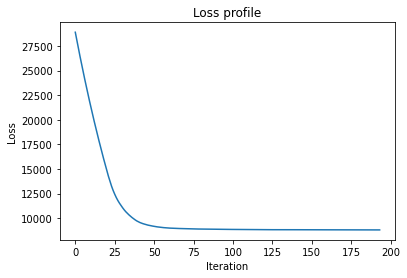

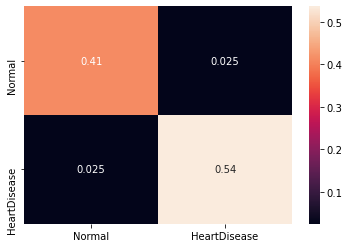

Classifier accuracy is: 0.9492753623188406 
recall per class is: 
    [0.94214876 0.95483871] 
precision per class is: 
    [0.94214876 0.95483871]


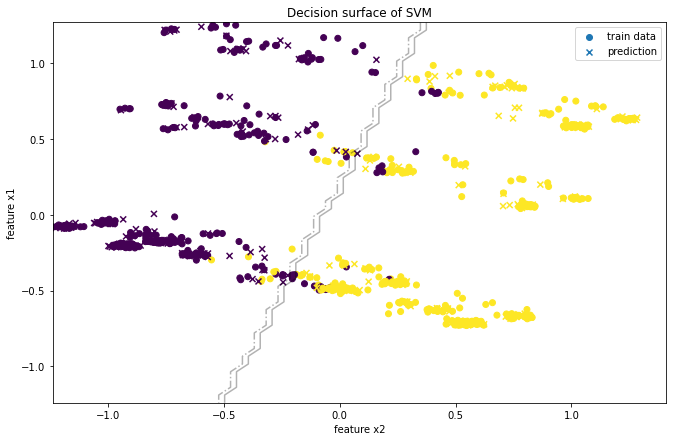

In [7]:
# now we can try pca with 2 components

clf = SVM(kernel='linear', C=45, gamma=1e-1)
clf.fit(X_train_pca, y_train_pca, n_iters=1500, lr=1e-6)

predictions = clf.predict(X_test_pca)

# evaluate predictions

clf._plot_loss()

cmf = confusion_matrix(y_test_pca, predictions)
plot_cm(cmf, labels=("Normal", "HeartDisease"), normalize=True)
print(f"Classifier accuracy is: {accuracy(cmf)} \n"
      f"recall per class is: \n"
      f"    {recall(cmf)} \n"
      f"precision per class is: \n"
      f"    {precision(cmf)}")

plot_prediction(clf, X_train_pca, X_test_pca, y_train_pca)

Po `PCA` transformácii náš klasifikátor skonvergoval už po pár iteráciach. Optimálne hodnoty `C`, `gamma` a `lr` boli
opäť testované ručne. Na scatterplote vidíme, že dáta sú po `PCA` transformácii relatívne dobre lineárne separovateľné
čo poukazuje aj na vysokú testovaciu `accuracy` zhruba 95%.

# SVM s polynomiálnym jadrom

Polynomiálne jadro by nám malo pomôcť separovať naše dáta vo viacrozmernom priestore príznakov. Hodnoty `C`, `gamma` a
 `lr` a boli znovu vyčepávajúco testované pričom prezentované sú len relevantné hodnoty.


  1%|          | 12.0/1500 [00:01<02:36,  9.49it/s]


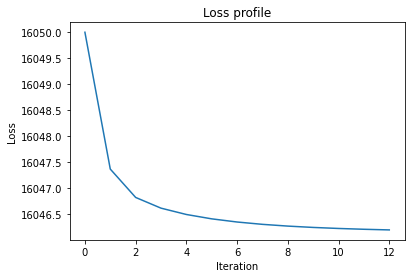

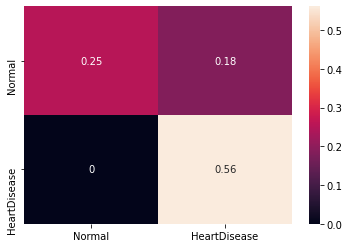

Classifier accuracy is: 0.8152173913043478 
recall per class is: 
    [0.5785124 1.       ] 
precision per class is: 
    [1.         0.75242718]


In [13]:
#  build & train model
clf = SVM(kernel='poly', C=25, gamma=1e-2, degree=3.0)
clf.fit(X_train, y_train, n_iters=1500, lr=1e-1)

# 5. Make predictions
predictions = clf.predict(X_test)

#  Evaluate predictions

clf._plot_loss()

cmf = confusion_matrix(y_test, predictions)
plot_cm(cmf, labels=("Normal", "HeartDisease"), normalize=True)
print(f"Classifier accuracy is: {accuracy(cmf)} \n"
      f"recall per class is: \n"
      f"    {recall(cmf)} \n"
      f"precision per class is: \n"
      f"    {precision(cmf)}")



Použitie polynomiálneho jadra vskutku pomohlo predikcii. Získali sme relatívne dobré výsledky. `Accuracy` na testovacom
datasete dosiahla hodnotu zhruba 81%. Na konfúznej matici tiež vidíme, že klasifikátor v 18% predikoval falošne
 pozitívne, že pacient má srdcovú chorobu čo je ale podstatné je to, že klasifikátor nepredikoval falošne negatívne.

Ďalej sa pokúsme vylepšiť predikciu použitím `RBF` jadra, ktoré je asi najčastejšie používaným jadrom v `SVM`.

# SVM s RBF jadrom


 21%|██        | 313.0/1500 [00:09<00:36, 32.27it/s]


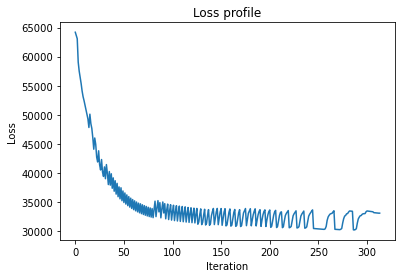

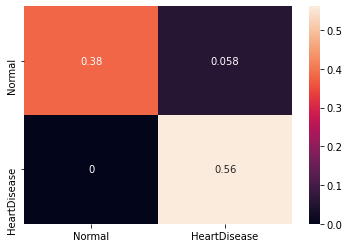

Classifier accuracy is: 0.9420289855072463 
recall per class is: 
    [0.8677686 1.       ] 
precision per class is: 
    [1.         0.90643275]


In [14]:
params = [{'kernel': 'rbf', 'C': 100, 'gamma': 1e-4, 'lr': 1e-6},
          {'kernel': 'rbf', 'C': 100, 'gamma': 1e-2, 'lr': 1e-5},  # optimal
          {'kernel': 'linear', 'C': 100, 'gamma': 1e-3, 'lr': 1e-4},  # slow convergence
          {'kernel': 'poly', 'C': 100, 'gamma': 1e-2, 'lr': 1e-4, 'degree': 2.0},
          {'kernel': 'poly', 'C': 100, 'gamma': 1e-1, 'lr': 1e-2, 'degree': 5.0},  # reasonable result
          {'kernel': 'poly', 'C': 100, 'gamma': 1e-1, 'lr': 1e-1, 'degree': 5.0},
          {'kernel': 'poly', 'C': 25, 'gamma': 1e-2, 'lr': 1e-1, 'degree': 2.0},
          {'kernel': 'poly', 'C': 25, 'gamma': 1e-2, 'lr': 1e-1, 'degree': 3.0},
          {'kernel': 'rbf', 'C': 25, 'gamma': 1e-1, 'lr': 1e-5},  # 1.0 accuracy; with 1e-5 lr on component 2
          {'kernel': 'linear', 'C': 45, 'gamma': 1e-1, 'lr': 1e-6}]
#  build & train model
clf = SVM(kernel='rbf', C=100, gamma=1e-2)
clf.fit(X_train, y_train, n_iters=1500, lr=1e-5)

# 5. Make predictions
predictions = clf.predict(X_test)

#  Evaluate predictions

clf._plot_loss()

cmf = confusion_matrix(y_test, predictions)
plot_cm(cmf, labels=("Normal", "HeartDisease"), normalize=True)
print(f"Classifier accuracy is: {accuracy(cmf)} \n"
      f"recall per class is: \n"
      f"    {recall(cmf)} \n"
      f"precision per class is: \n"
      f"    {precision(cmf)}")


  7%|▋         | 104.0/1500 [00:03<00:49, 28.00it/s]


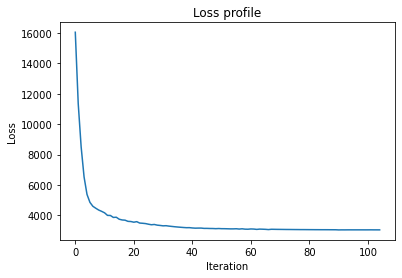

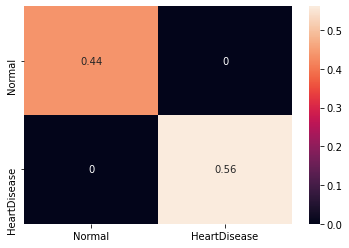

Classifier accuracy is: 1.0 
recall per class is: 
    [1. 1.] 
precision per class is: 
    [1. 1.]


In [15]:
clf = SVM(kernel='rbf', C=25, gamma=1e-1)
clf.fit(X_train, y_train, n_iters=1500, lr=1e-5)

# 5. Make predictions
predictions = clf.predict(X_test)

#  Evaluate predictions

clf._plot_loss()

cmf = confusion_matrix(y_test, predictions)
plot_cm(cmf, labels=("Normal", "HeartDisease"), normalize=True)
print(f"Classifier accuracy is: {accuracy(cmf)} \n"
      f"recall per class is: \n"
      f"    {recall(cmf)} \n"
      f"precision per class is: \n"
      f"    {precision(cmf)}")

Použitie `RBF` jadra prinieslo ďalšie zlepšenie predikčných vlastností klasifikátora. S vhodným nastavením
 hyperparametrov bolo dokonca možné získať `accuracy` rovnú 100%. Nakoniec ešte použime SVM s `RBF` jadrom na
 transformované dáta pomocou PCA aby sme mohli predikciu jednoducho vizualizovať.


100%|██████████| 1500.0/1500 [00:47<00:00, 31.63it/s]


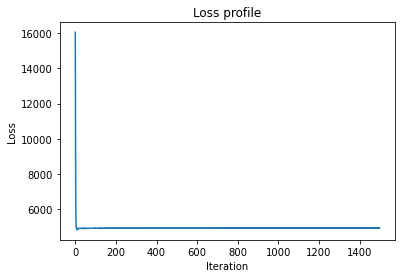

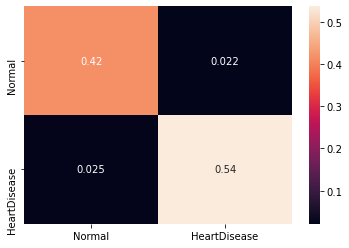

Classifier accuracy is: 0.9528985507246377 
recall per class is: 
    [0.95041322 0.95483871] 
precision per class is: 
    [0.94262295 0.96103896]


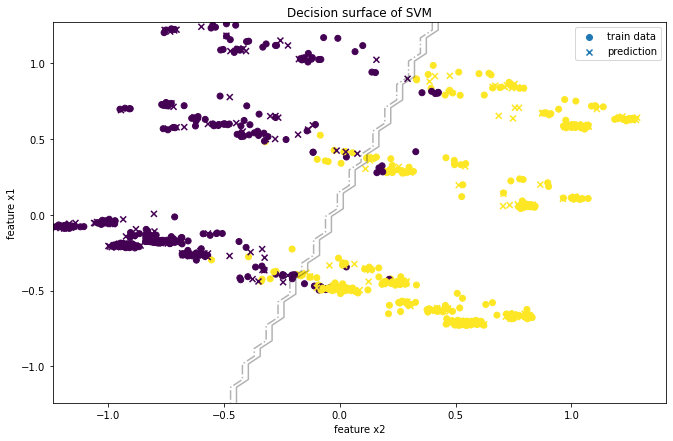

In [17]:
# try pca with 2 components

clf = SVM(kernel='rbf', C=25, gamma=1e-1)
clf.fit(X_train_pca, y_train_pca, n_iters=1500, lr=1e-5)

predictions = clf.predict(X_test_pca)

# evaluate predictions

clf._plot_loss()

cmf = confusion_matrix(y_test_pca, predictions)
plot_cm(cmf, labels=("Normal", "HeartDisease"), normalize=True)
print(f"Classifier accuracy is: {accuracy(cmf)} \n"
      f"recall per class is: \n"
      f"    {recall(cmf)} \n"
      f"precision per class is: \n"
      f"    {precision(cmf)}")

plot_prediction(clf, X_train_pca, X_test_pca, y_train_pca)


# Záver

Videli sme použitie kernelizovaného algoritmu SVM. Samotný algoritmus sa ukázal byť veľmi závislý na hyperparametroch a
síce použitom jadre pričom použitie `RBF` sa ukázalo byť najvhodnejšou voľbou, parametri C, ktorý korešponduje s
maximálnym povoleným počtom chýb v klasifikácii a ďalej na
parametri `gamma`, ktorý v implementácii slúžil na stabilizáciu výpočtu nakoľko v lineárnom a polynomiálnom jadre s veľkými
rozmermi dochádzalo často k pretečeniu (po výpočte kvadratickej formy alebo skalárneho súčinu). Implementácia pomocou
`gradient descentu` priniesla ďalší optimalizovateľný parameter a síce `learning rate` (`lr`). Samotné ladenie
algoritmu sa tak stalo veľmi časovo náročné a vyžadovalo by automatizáciu. Nakoniec ešte podotknime, že aj pri použití
`just-in time` kompilácie pri implementácii `gradient descentu`,bol celkový výpočetný čas relatívne vysoký a zjavne
sa často stávalo, že sa algoritmus zasekol v lokálnom minime. Pravdepodobne kvôli väčšine spomenutých nevýhod našej
implementácie nájdeme SVM implementované v štandarných balíkoch pomocou kvadratickej optimalizácie namiesto
`gradient descentu`.
